# Data challenge: Investigating a drop in user engagement at Yammer


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Load-the-datasets" data-toc-modified-id="Load-the-datasets-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the datasets</a></span></li><li><span><a href="#Insights-from-the-users-dataset" data-toc-modified-id="Insights-from-the-users-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Insights from the users dataset</a></span></li><li><span><a href="#Insights-from-the-events-dataset" data-toc-modified-id="Insights-from-the-events-dataset-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Insights from the events dataset</a></span></li><li><span><a href="#Insights-from-the-email-dataset" data-toc-modified-id="Insights-from-the-email-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Insights from the email dataset</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

List of possible causes for the dip in user retention during the first week of August 2014 (~ 200 users lost):

* Some Yammer users went on vacation 
* Something changed in the Yammer app that users don't like
* There is a bug for a specific engagment that users cannot access anymore
* A better alternative arrived on the market and some users churned

## Exploratory Data Analysis 
### Load the datasets

In [2]:
import numpy as np
import pandas as pd
import datetime
import time
from time import gmtime, strftime
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Load the user dataset
users = pd.read_csv('yammer_users.csv')
# Load the event dataset
events = pd.read_csv('yammer_events.csv')
# Load the email dataset
emails = pd.read_csv('yammer_emails.csv')
# Load the rollup dataset
rollup = pd.read_csv('dimension_rollup_periods.csv')

### Insights from the users dataset
Let's explore the first dataset of users:

In [ ]:
users.describe(include='all')
#[len(users.user_id.value_counts()),len(users.company_id.value_counts())]

This is interesting... Yammer has ~ 19k users, distributed among ~ 13k companies. Are most users talking to themselves?

In [ ]:
pd.crosstab(users.language, users.state,margins=True).plot(kind="bar",figsize=(10, 5))
plt.show()

About half of the engagements are done in English, which is not very surprising! For each language, it looks like 50% of the users are active, and 50% are inactive. Fun fact, most of France (and many other European countries) go on vacation the first week of August, which could play a role in the decrease of user activity observed during that time.
Now, let's have a look at when users signed up, and activated their accounts:

Working with dates is not very straightforward, and since we are looking at things on a weekly timescale, it makes sense to transform the date columns into calendar week (1 to 52):

In [ ]:
users['created_at'] = pd.to_datetime(users['created_at'])
users['week_created'] = users['created_at'].dt.week
users['year_created'] = users['created_at'].dt.year
users['activated_at'] = pd.to_datetime(users['activated_at'])
users['week_activated'] = users['activated_at'].dt.week
users['year_activated'] = users['activated_at'].dt.year

plt.figure(2,figsize=(15, 5))
plt.subplot(121)
Yr13 = users.loc[users['year_created']==2013]
Yr14 = users.loc[users['year_created']==2014]
plt.plot(Yr13.groupby('week_created').week_created.count(), marker='o', label='2013')
plt.plot(Yr14.groupby('week_created').week_created.count(), marker='o', label='2014')
plt.ylabel('Created accounts')
plt.xlabel('Calendar week')
plt.legend()
plt.subplot(122)
Yr13 = users.loc[users['year_activated']==2013]
Yr14 = users.loc[users['year_activated']==2014]
plt.plot(Yr13.groupby('week_activated').week_created.count(), marker='o', label='2013')
plt.plot(Yr14.groupby('week_activated').week_created.count(), marker='o', label='2014')
plt.ylabel('Activated accounts')
plt.xlabel('Calendar week')
plt.legend()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.15)

plt.show()

We can observe again that only half of the account created are actually activated. Besides the difference in magnitude, the trends observed for the number of activated accounts is similar to the number of created accounts. The number of accounts slowly ramped up during 2013, and increased twice as fast during the first two semesters of 2014.

### Insights from the events dataset

In [3]:
events.describe(include='all')
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


Again, we should transform the date column into calendar week:

In [4]:
events['occurred_at'] = pd.to_datetime(events['occurred_at'])
events['week'] = events['occurred_at'].dt.week
events['year'] = events['occurred_at'].dt.year

Let's start by having a look at the distribution of each feature.

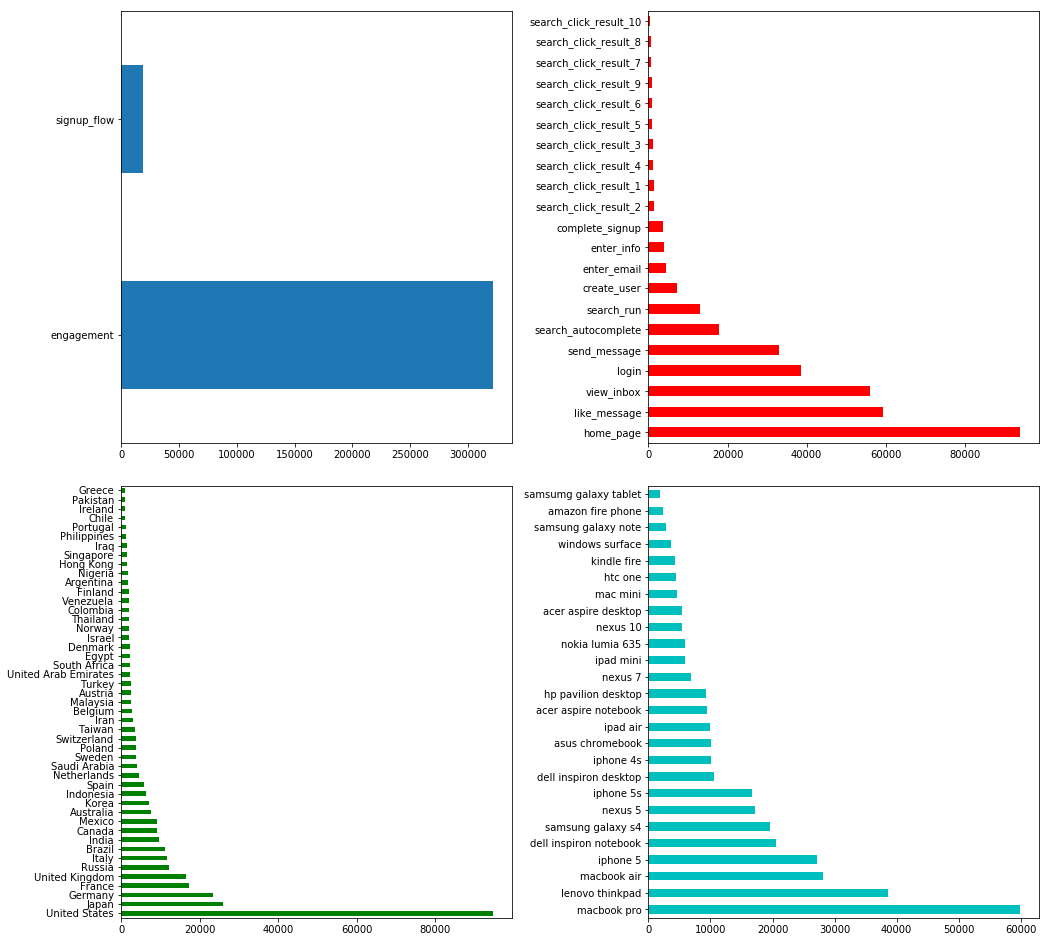

In [5]:
plt.figure(3,figsize=(15, 15))
plt.subplot(221)
events.event_type.value_counts().plot(kind="barh")
plt.subplot(222)
events.event_name.value_counts().plot(kind="barh", color='r')
plt.subplot(223)
events.location.value_counts().plot(kind="barh", color='g')
plt.subplot(224)
events.device.value_counts().plot(kind="barh", color='c')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

The vast majority of the events are engagements and not sign up (which makes a lot of sense), and most of them consist in interacting with the home page, sending / liking messages and viewing the inbox. Regarding the location, it closely follows the distribution of the languages shown above and the core user base of Yammer is clearly in the US. An interesting characteristic regarding the devices is that a significant portion of the users are interacting with Yammer on their phone in addition to their laptop (liking a message vs. writing it for instance).

Before going further, we need to look at the number of users who did at least one engagement per week. This means that we need to be careful and not take into account more than one engagement / user / week :

In [6]:
# Only focus on engagement, not sign up:
engagements = events.drop(events.event_type == 'signup_flow')
# Only keep the first engagement of the week for each user
# engagements = events.drop_duplicates(["user_id","week"], keep='first')
# engagements.head()

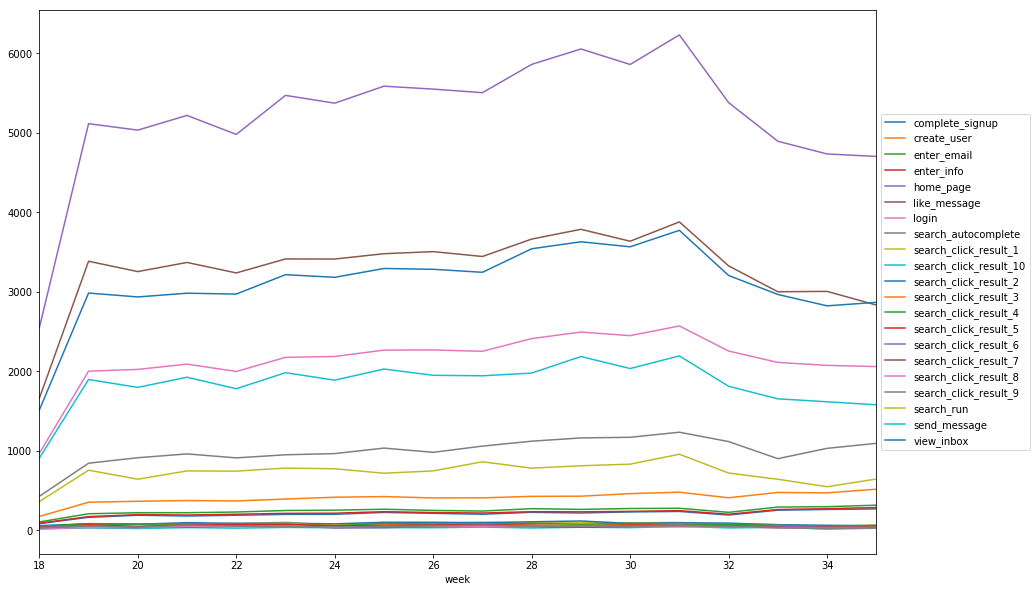

In [89]:
# First, we should look at the evolution of each engagement over time:
test = engagements.groupby(['week','event_name']).event_name.count()
test.unstack().plot(figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    


The dip in engagement around week 30 of 2014 is observed for every type of action, which indicates that the trend might be due to users, and not a particular functionality in the app.

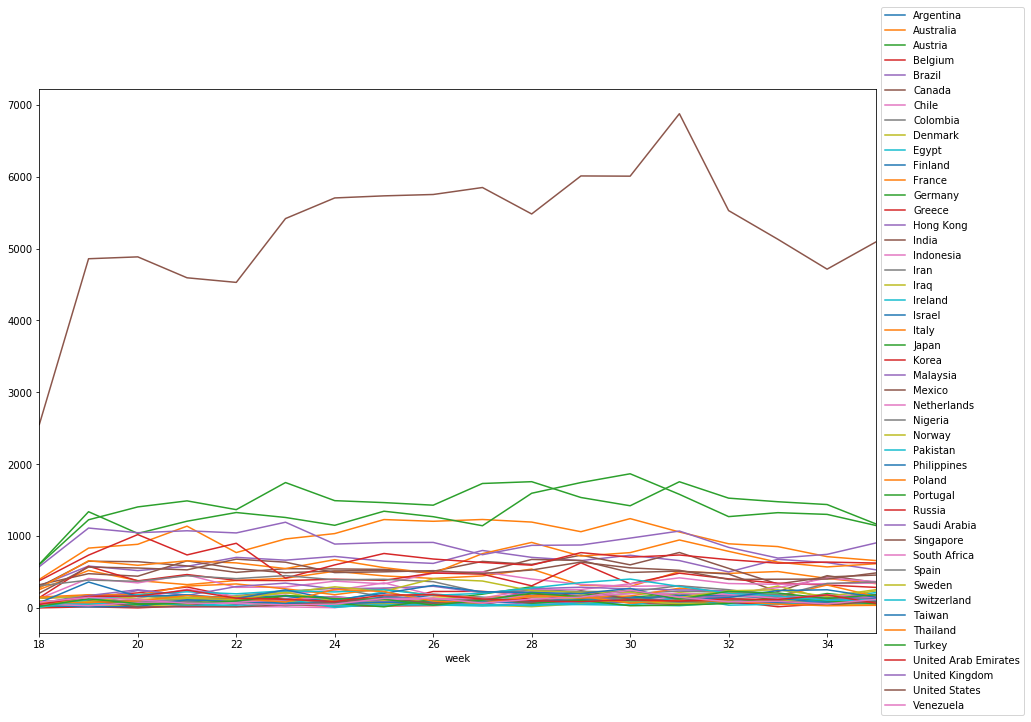

In [90]:
# First, we should look at the evolution of the engagements in each location over time:
test2 = engagements.groupby(['week','location']).location.count()
test2.unstack().plot(figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

A quick look at that plot shows that Yammer lost most of the engagements in the US. Did anything particular happened during summer 2014?

### Insights from the email dataset

In [67]:
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [93]:
emails['occurred_at'] = pd.to_datetime(events['occurred_at'])
emails['week'] = emails['occurred_at'].dt.week
emails['year'] = emails['occurred_at'].dt.year

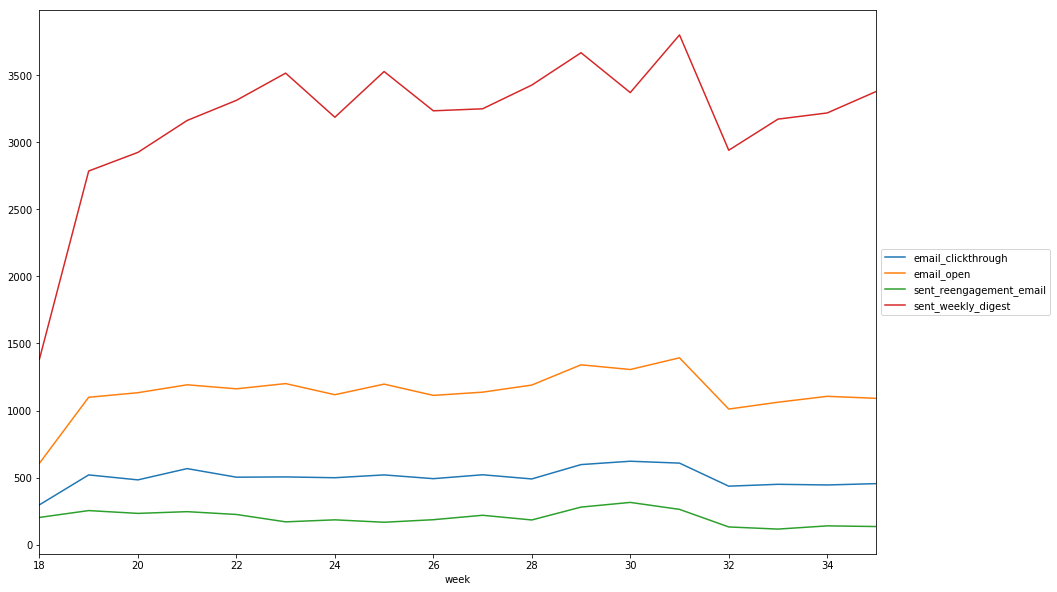

In [94]:
test2 = emails.groupby(['week','action']).action.count()
test2.unstack().plot(figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

There is a clear decrease in the number of weekly digests sent, which could translate into less user engagements around week 30.

## Conclusions

The dip in user retention observed around week 30 in 2014 was mostly focused on US users, and affected every kind of engagements. The culprit is probably the decrease in the number of weekly digests sent, leading to less users logging into their account that week.